In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    # Find similar users based on their preferences
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)  # Average rating for the given songs
    similar_users = similar_users.nlargest(3).index.tolist()  # Get 3 most similar users

    # Get recommendations from similar users
    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:  # Only recommend songs not in the new user's preferences
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    # Return top recommendations
    return recommendations.nlargest(5)

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    # Calculate cosine similarity between songs
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    # Get songs rated by the user
    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    # Get recommendations based on similar songs
    recommendations = pd.Series(dtype=float)
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()  # Get 5 most similar songs
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:  # Only recommend songs the user hasn't rated
                recommendations[similar_song] = recommendations.get(similar_song, 0) + song_similarity_df[song][similar_song]

    # If no recommendations are found, fallback to most similar songs globally
    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5)

    # Return top recommendations
    return recommendations.nlargest(5)

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        # If it's a new user with preferences
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        return get_user_user_recommendations_for_new_user(preferences)
    elif user_id is not None:
        # If it's an existing user
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        return get_item_item_recommendations_for_existing_user(user_id)
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Print recommendations for both cases
print(recommend_songs(existing_user))  # For existing user using item-item filtering
print(recommend_songs(preferences=new_user_preferences))  # For new user using user-user filtering


Item-Item Filtering Recommendations for Existing User 1:
4    1.523766
dtype: float64
User-User Filtering Recommendations for New User (Based on Preferences):
3    8.0
4    7.0
dtype: float64


Item-Item Filtering Recommendations for Existing User 1:
User-User Filtering Recommendations for New User (Based on Preferences):


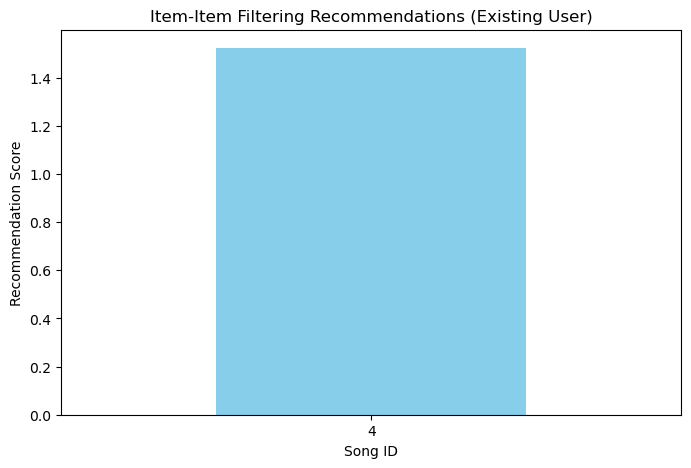

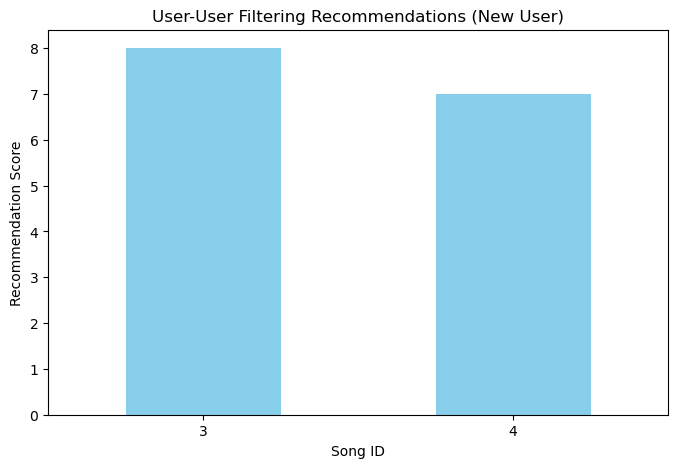

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    # Find similar users based on their preferences
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    # Get recommendations from similar users
    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    return recommendations.nlargest(5)

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                recommendations[similar_song] = recommendations.get(similar_song, 0) + song_similarity_df[song][similar_song]

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5)

    return recommendations.nlargest(5)

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        return get_user_user_recommendations_for_new_user(preferences)
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        return get_item_item_recommendations_for_existing_user(user_id)
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Function to plot the recommendations
def plot_recommendations(recommendations, title):
    plt.figure(figsize=(8, 5))
    recommendations.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Recommendation Score')
    plt.xticks(rotation=0)
    plt.show()

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for both cases
item_item_recommendations = recommend_songs(existing_user)
user_user_recommendations = recommend_songs(preferences=new_user_preferences)

# Plot the recommendations
plot_recommendations(item_item_recommendations, 'Item-Item Filtering Recommendations (Existing User)')
plot_recommendations(user_user_recommendations, 'User-User Filtering Recommendations (New User)')


Item-Item Filtering Recommendations for Existing User 1:
User-User Filtering Recommendations for New User (Based on Preferences):
Item-Item Filtering Recommendations (Existing User):
4    1.523766
dtype: float64

User-User Filtering Recommendations (New User):
3    8.0
4    7.0
dtype: float64


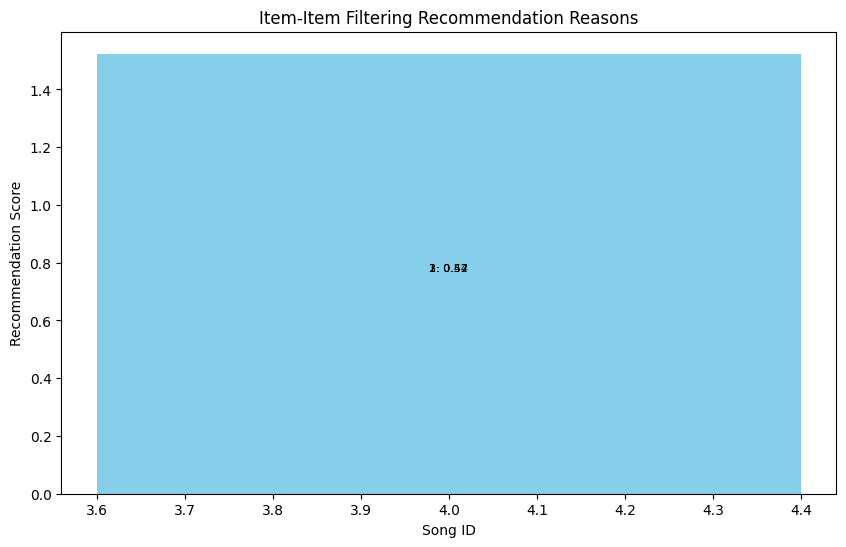

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    return recommendations.nlargest(5)

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    reasons = {}
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score
                if similar_song not in reasons:
                    reasons[similar_song] = [(song, score)]
                else:
                    reasons[similar_song].append((song, score))

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5), None

    return recommendations.nlargest(5), reasons

# Function to plot the recommendation reasons (similarity scores)
def plot_recommendation_reasons(recommendations, reasons, title):
    plt.figure(figsize=(10, 6))
    for song, reason_list in reasons.items():
        song_scores = [score for _, score in reason_list]
        plt.bar(song, np.sum(song_scores), color='skyblue')
        # Annotate with contributing song IDs and scores
        for contributing_song, score in reason_list:
            plt.text(song, np.sum(song_scores) / 2, f'{contributing_song}: {score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Recommendation Score')
    plt.xticks(rotation=0)
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        return get_user_user_recommendations_for_new_user(preferences), None
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        return get_item_item_recommendations_for_existing_user(user_id)
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for existing user using item-item filtering
item_item_recommendations, item_item_reasons = recommend_songs(user_id=existing_user)

# Get recommendations for new user using user-user filtering
user_user_recommendations, _ = recommend_songs(preferences=new_user_preferences)

# Print recommendations
print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)

# Plot the reasons for item-item filtering recommendations
if item_item_reasons:
    plot_recommendation_reasons(item_item_recommendations, item_item_reasons, 'Item-Item Filtering Recommendation Reasons')


Item-Item Filtering Recommendations for Existing User 1:
User-User Filtering Recommendations for New User (Based on Preferences):
Item-Item Filtering Recommendations (Existing User):
4    1.523766
dtype: float64

User-User Filtering Recommendations (New User):
3    8.0
4    7.0
dtype: float64


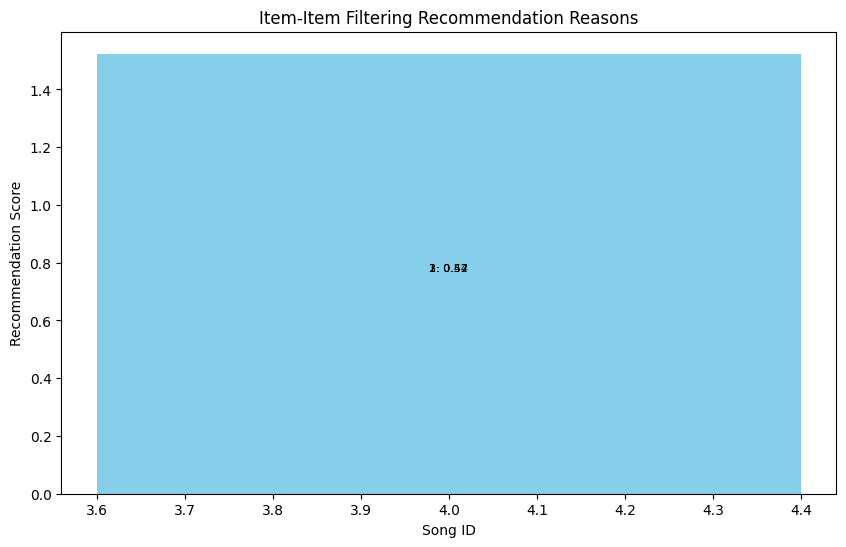

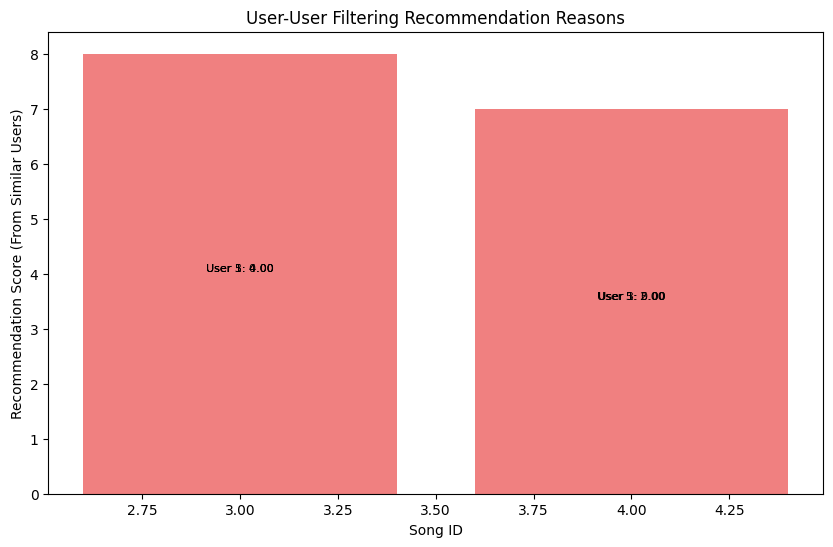

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    reasons = {}

    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]
                if song_id not in reasons:
                    reasons[song_id] = [(user, user_ratings[song_id])]
                else:
                    reasons[song_id].append((user, user_ratings[song_id]))

    return recommendations.nlargest(5), reasons

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    reasons = {}

    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score
                if similar_song not in reasons:
                    reasons[similar_song] = [(song, score)]
                else:
                    reasons[similar_song].append((song, score))

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5), None

    return recommendations.nlargest(5), reasons

# Function to plot the recommendation reasons (similarity scores)
def plot_recommendation_reasons(recommendations, reasons, title):
    plt.figure(figsize=(10, 6))
    for song, reason_list in reasons.items():
        song_scores = [score for _, score in reason_list]
        plt.bar(song, np.sum(song_scores), color='skyblue')
        for contributing_song, score in reason_list:
            plt.text(song, np.sum(song_scores) / 2, f'{contributing_song}: {score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Recommendation Score')
    plt.xticks(rotation=0)
    plt.show()

# Function to plot user-user filtering reasons
def plot_user_user_reasons(recommendations, reasons, title):
    plt.figure(figsize=(10, 6))
    for song, reason_list in reasons.items():
        song_scores = [score for _, score in reason_list]
        plt.bar(song, np.sum(song_scores), color='lightcoral')
        for user, score in reason_list:
            plt.text(song, np.sum(song_scores) / 2, f'User {user}: {score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Recommendation Score (From Similar Users)')
    plt.xticks(rotation=0)
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        return get_user_user_recommendations_for_new_user(preferences)
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        return get_item_item_recommendations_for_existing_user(user_id)
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for existing user using item-item filtering
item_item_recommendations, item_item_reasons = recommend_songs(user_id=existing_user)

# Get recommendations for new user using user-user filtering
user_user_recommendations, user_user_reasons = recommend_songs(preferences=new_user_preferences)

# Print recommendations
print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)

# Plot the reasons for item-item filtering recommendations
if item_item_reasons:
    plot_recommendation_reasons(item_item_recommendations, item_item_reasons, 'Item-Item Filtering Recommendation Reasons')

# Plot the reasons for user-user filtering recommendations
if user_user_reasons:
    plot_user_user_reasons(user_user_recommendations, user_user_reasons, 'User-User Filtering Recommendation Reasons')


Item-Item Filtering Recommendations for Existing User 1:
User-User Filtering Recommendations for New User (Based on Preferences):
Item-Item Filtering Recommendations (Existing User):
4    1.523766
dtype: float64

User-User Filtering Recommendations (New User):
3    8.0
4    7.0
dtype: float64


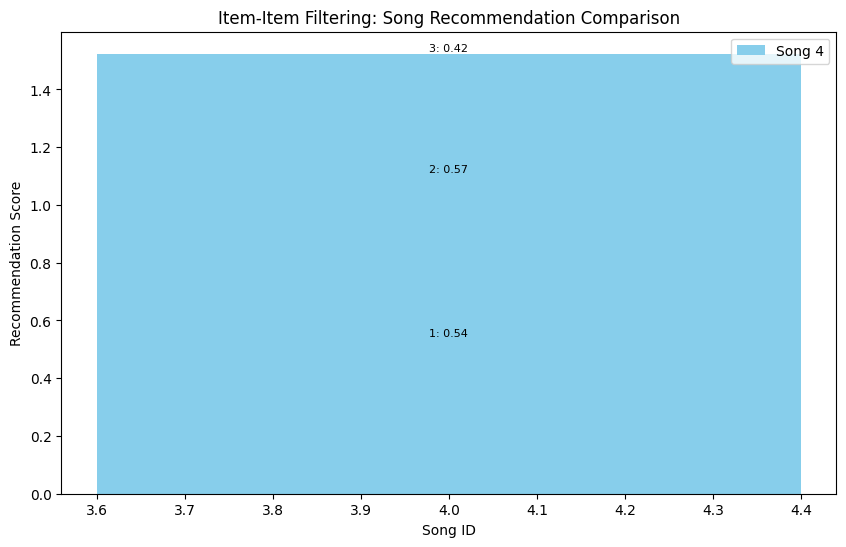

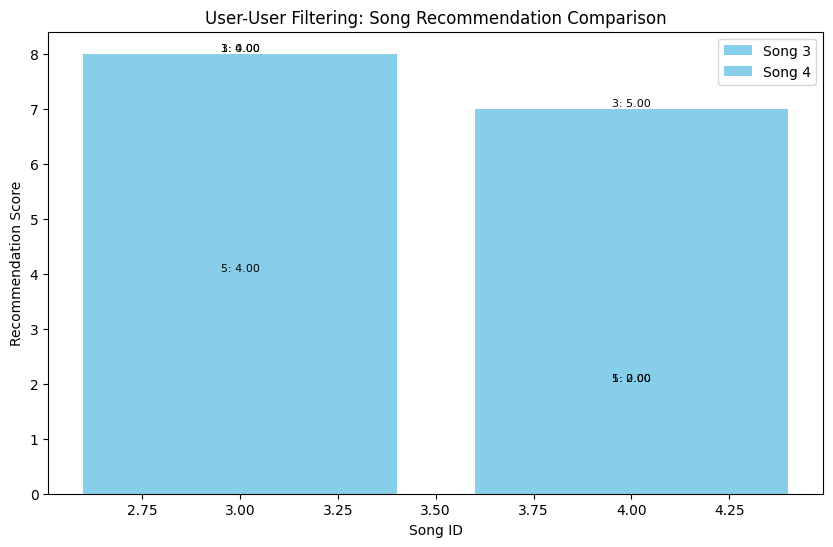

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    reasons = {}

    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]
                if song_id not in reasons:
                    reasons[song_id] = [(user, user_ratings[song_id])]
                else:
                    reasons[song_id].append((user, user_ratings[song_id]))

    return recommendations.nlargest(5), reasons

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    reasons = {}

    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score
                if similar_song not in reasons:
                    reasons[similar_song] = [(song, score)]
                else:
                    reasons[similar_song].append((song, score))

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5), None

    return recommendations.nlargest(5), reasons

# Function to plot the comparison between songs
def plot_song_comparisons(recommendations, reasons, title):
    songs = list(recommendations.index)
    song_scores = [recommendations[song] for song in songs]

    plt.figure(figsize=(10, 6))

    # Stacked bar chart showing contributions for each song
    for song, reason_list in reasons.items():
        score_contributions = [score for _, score in reason_list]
        contributors = [contributor for contributor, _ in reason_list]
        plt.bar(song, np.sum(score_contributions), color='skyblue', label=f"Song {song}")
        for idx, (contributor, score) in enumerate(reason_list):
            plt.text(song, np.sum(score_contributions[:idx + 1]), f'{contributor}: {score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Recommendation Score')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        return get_user_user_recommendations_for_new_user(preferences)
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        return get_item_item_recommendations_for_existing_user(user_id)
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for existing user using item-item filtering
item_item_recommendations, item_item_reasons = recommend_songs(user_id=existing_user)

# Get recommendations for new user using user-user filtering
user_user_recommendations, user_user_reasons = recommend_songs(preferences=new_user_preferences)

# Print recommendations
print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)

# Plot the song comparison for item-item filtering
if item_item_reasons:
    plot_song_comparisons(item_item_recommendations, item_item_reasons, 'Item-Item Filtering: Song Recommendation Comparison')

# Plot the song comparison for user-user filtering
if user_user_reasons:
    plot_song_comparisons(user_user_recommendations, user_user_reasons, 'User-User Filtering: Song Recommendation Comparison')


Item-Item Filtering Recommendations for Existing User 1:
User-User Filtering Recommendations for New User (Based on Preferences):
Item-Item Filtering Recommendations (Existing User):
4    1.523766
dtype: float64

User-User Filtering Recommendations (New User):
3    8.0
4    7.0
dtype: float64


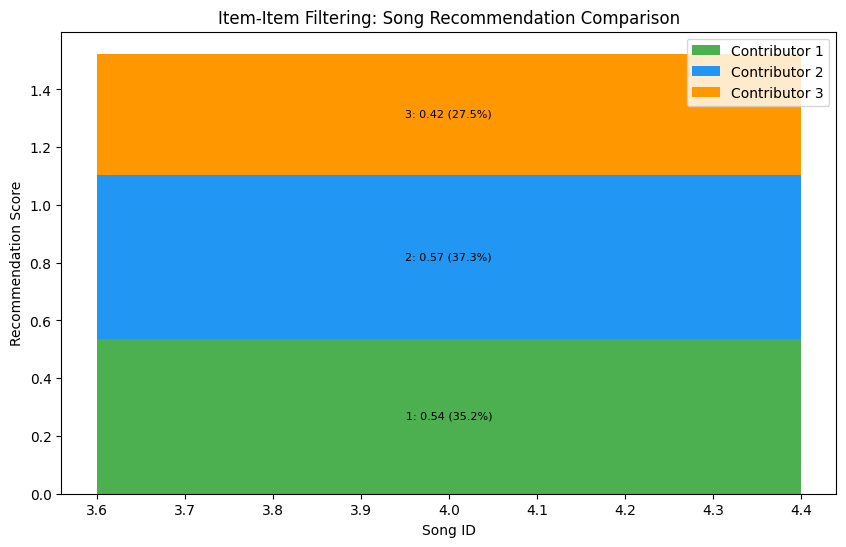

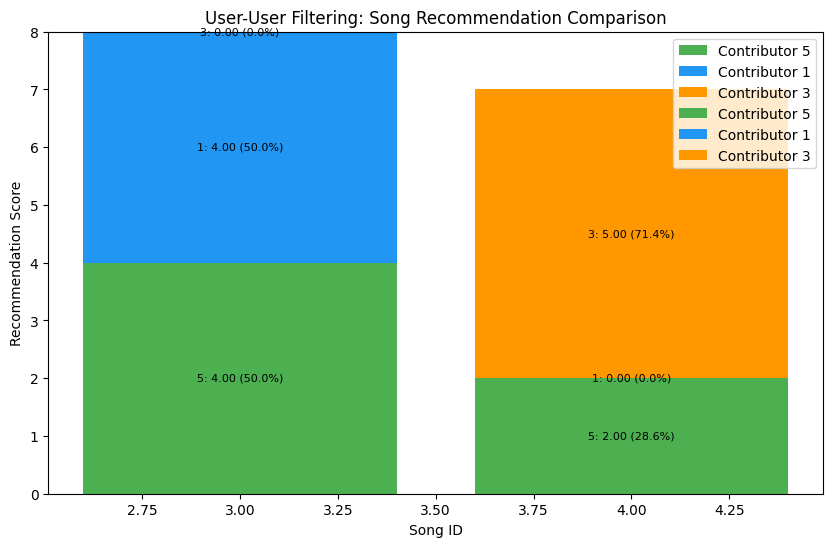

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    reasons = {}

    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]
                if song_id not in reasons:
                    reasons[song_id] = [(user, user_ratings[song_id])]
                else:
                    reasons[song_id].append((user, user_ratings[song_id]))

    return recommendations.nlargest(5), reasons

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    reasons = {}

    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score
                if similar_song not in reasons:
                    reasons[similar_song] = [(song, score)]
                else:
                    reasons[similar_song].append((song, score))

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5), None

    return recommendations.nlargest(5), reasons

# Function to plot the comparison between songs
def plot_song_comparisons(recommendations, reasons, title):
    songs = list(recommendations.index)
    song_scores = [recommendations[song] for song in songs]

    plt.figure(figsize=(10, 6))

    # Colors for clarity
    colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#FF5722']

    # Stacked bar chart showing contributions for each song
    for i, song in enumerate(songs):
        reason_list = reasons[song]
        total_score = sum([score for _, score in reason_list])
        bottom = 0
        for idx, (contributor, score) in enumerate(reason_list):
            percentage = (score / total_score) * 100  # Calculate percentage contribution
            plt.bar(song, score, bottom=bottom, color=colors[idx % len(colors)], label=f"Contributor {contributor}")
            plt.text(song, bottom + score / 2, f'{contributor}: {score:.2f} ({percentage:.1f}%)', ha='center', va='center', fontsize=8)
            bottom += score

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Recommendation Score')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        return get_user_user_recommendations_for_new_user(preferences)
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        return get_item_item_recommendations_for_existing_user(user_id)
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for existing user using item-item filtering
item_item_recommendations, item_item_reasons = recommend_songs(user_id=existing_user)

# Get recommendations for new user using user-user filtering
user_user_recommendations, user_user_reasons = recommend_songs(preferences=new_user_preferences)

# Print recommendations
print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)

# Plot the song comparison for item-item filtering
if item_item_reasons:
    plot_song_comparisons(item_item_recommendations, item_item_reasons, 'Item-Item Filtering: Song Recommendation Comparison')

# Plot the song comparison for user-user filtering
if user_user_reasons:
    plot_song_comparisons(user_user_recommendations, user_user_reasons, 'User-User Filtering: Song Recommendation Comparison')


Item-Item Filtering Recommendations for Existing User 1:


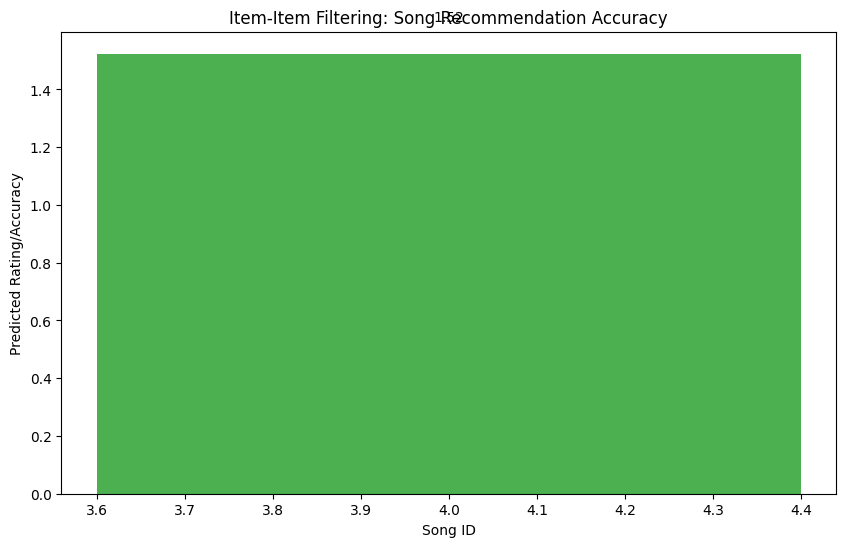

User-User Filtering Recommendations for New User (Based on Preferences):


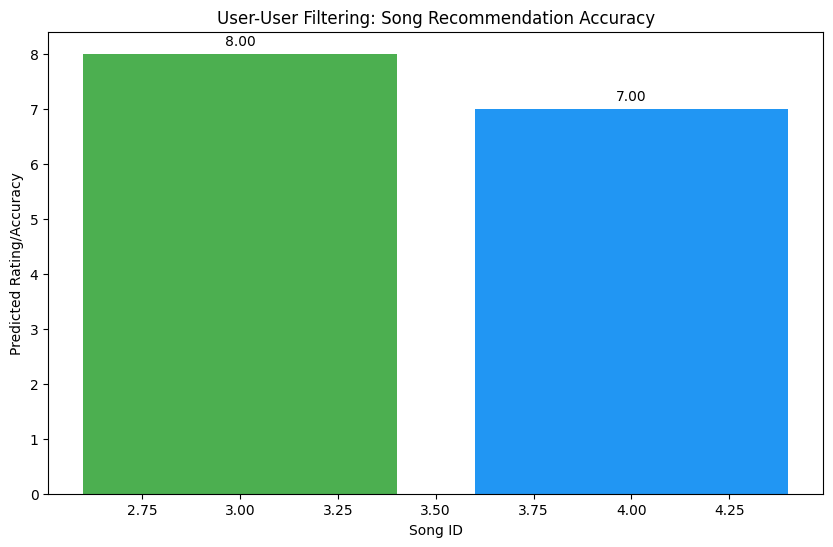

Item-Item Filtering Recommendations (Existing User):
4    1.523766
dtype: float64

User-User Filtering Recommendations (New User):
3    8.0
4    7.0
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    return recommendations.nlargest(5)

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5)

    return recommendations.nlargest(5)

# Function to plot the comparison between songs with their accuracy/precision values
def plot_song_accuracy_comparisons(recommendations, title):
    songs = list(recommendations.index)
    song_scores = [recommendations[song] for song in songs]

    plt.figure(figsize=(10, 6))

    # Colors for clarity
    colors = ['#2196F3' if score != max(song_scores) else '#4CAF50' for score in song_scores]  # Highlight the recommended song

    # Bar chart showing accuracy/precision values for each song
    plt.bar(songs, song_scores, color=colors)

    # Add accuracy values to each bar
    for i, score in enumerate(song_scores):
        plt.text(songs[i], score + 0.1, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Predicted Rating/Accuracy')
    plt.xticks(rotation=0)
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        recommendations = get_user_user_recommendations_for_new_user(preferences)
        plot_song_accuracy_comparisons(recommendations, 'User-User Filtering: Song Recommendation Accuracy')
        return recommendations
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        recommendations = get_item_item_recommendations_for_existing_user(user_id)
        plot_song_accuracy_comparisons(recommendations, 'Item-Item Filtering: Song Recommendation Accuracy')
        return recommendations
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for existing user using item-item filtering
item_item_recommendations = recommend_songs(user_id=existing_user)

# Get recommendations for new user using user-user filtering
user_user_recommendations = recommend_songs(preferences=new_user_preferences)

# Print recommendations
print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)


Item-Item Filtering Recommendations for Existing User 1:


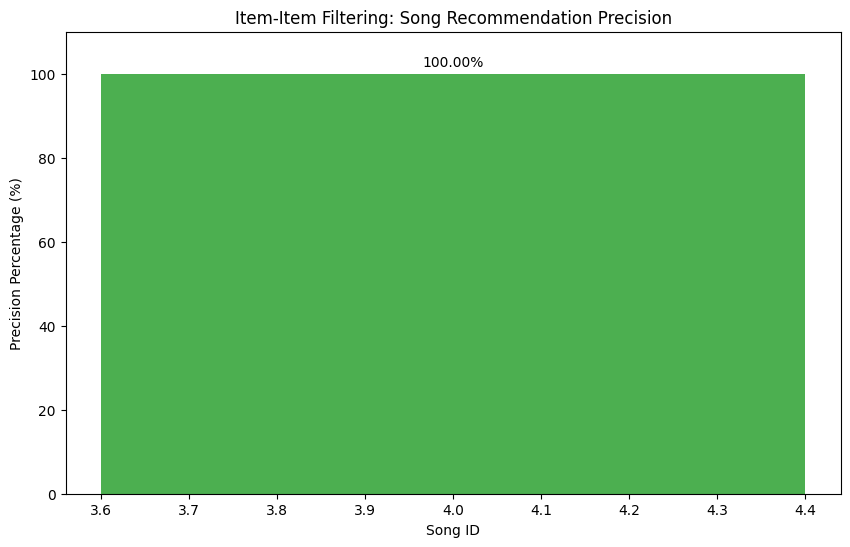

User-User Filtering Recommendations for New User (Based on Preferences):


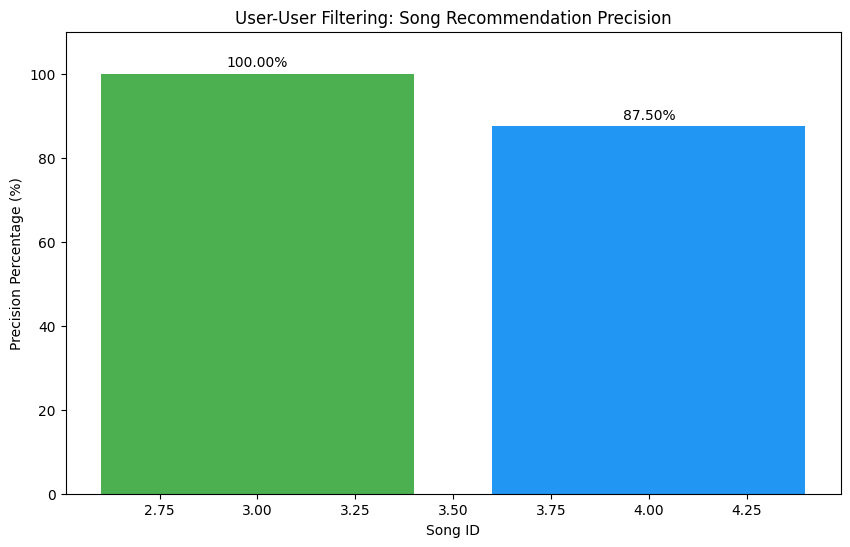

Item-Item Filtering Recommendations (Existing User):
4    1.523766
dtype: float64

User-User Filtering Recommendations (New User):
3    8.0
4    7.0
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    return recommendations.nlargest(5)

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5)

    return recommendations.nlargest(5)

# Function to plot the comparison between songs with their accuracy and precision percentage
def plot_song_precision_comparisons(recommendations, title):
    songs = list(recommendations.index)
    song_scores = [recommendations[song] for song in songs]

    # Calculate precision percentage
    max_score = max(song_scores)
    precision_percentages = [(score / max_score) * 100 for score in song_scores]

    plt.figure(figsize=(10, 6))

    # Colors for clarity
    colors = ['#2196F3' if score != max(song_scores) else '#4CAF50' for score in song_scores]  # Highlight the recommended song

    # Bar chart showing accuracy/precision values for each song
    bars = plt.bar(songs, precision_percentages, color=colors)

    # Add precision percentages to each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{precision_percentages[i]:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Precision Percentage (%)')
    plt.xticks(rotation=0)
    plt.ylim(0, 110)  # Set y-axis limit to 110 to leave space for labels
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        recommendations = get_user_user_recommendations_for_new_user(preferences)
        plot_song_precision_comparisons(recommendations, 'User-User Filtering: Song Recommendation Precision')
        return recommendations
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        recommendations = get_item_item_recommendations_for_existing_user(user_id)
        plot_song_precision_comparisons(recommendations, 'Item-Item Filtering: Song Recommendation Precision')
        return recommendations
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for existing user using item-item filtering
item_item_recommendations = recommend_songs(user_id=existing_user)

# Get recommendations for new user using user-user filtering
user_user_recommendations = recommend_songs(preferences=new_user_preferences)

# Print recommendations
print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)


Item-Item Filtering Recommendations for Existing User 1:
4    1.523766
dtype: float64

User-User Filtering Recommendations for New User (Based on Preferences):
3    8.0
4    7.0
dtype: float64


KeyError: 0

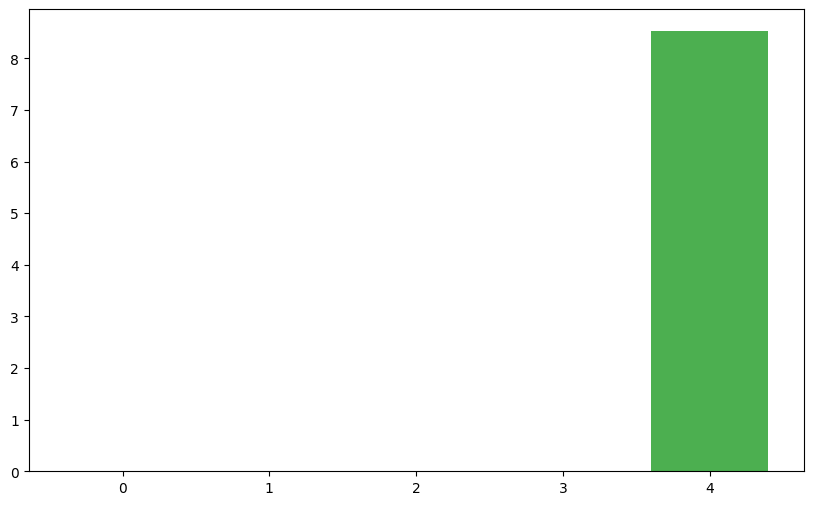

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sample dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5],
    'song_id': [1, 2, 3, 1, 3, 1, 2, 4, 1, 3, 4, 1, 2, 3, 4],
    'rating': [5, 3, 4, 4, 5, 2, 3, 5, 3, 4, 4, 5, 5, 4, 2]
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    return recommendations.nlargest(5)

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5)

    return recommendations.nlargest(5)

# Function to plot the comparison between songs with their predicted ratings
def plot_comparison_graph(item_item_rec, user_user_rec):
    # Combine both recommendations into a single DataFrame for comparison
    combined_recommendations = pd.concat([item_item_rec, user_user_rec], axis=0).reset_index()

    # Remove duplicates and sum scores
    combined_recommendations = combined_recommendations.groupby('index').sum().reset_index()

    # Ensure we have a song ID column
    combined_recommendations.columns = ['song_id', 'predicted_rating']

    # Ensure all song IDs are represented for the plot
    combined_recommendations = combined_recommendations.reindex(range(1, 6)).fillna(0)  # Adjust according to song IDs
    songs = combined_recommendations['song_id']
    scores = combined_recommendations['predicted_rating']

    plt.figure(figsize=(10, 6))

    # Colors for clarity
    colors = ['#4CAF50' if score == max(scores) else '#2196F3' for score in scores]  # Highlight the highest score

    bars = plt.bar(songs, scores, color=colors)

    # Add scores to each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{scores[i]:.2f}',
                 ha='center', va='bottom', fontsize=10)

    plt.title('Comparison of Recommended Songs')
    plt.xlabel('Song ID')
    plt.ylabel('Predicted Rating')
    plt.xticks(rotation=0)
    plt.ylim(0, max(scores) + 1)  # Set y-axis limit to leave space for labels
    plt.axhline(y=0, color='k')  # Add a baseline
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(existing_user_id=None, new_user_preferences=None):
    item_item_recommendations = pd.Series(dtype=float)
    user_user_recommendations = pd.Series(dtype=float)

    if existing_user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {existing_user_id}:")
        item_item_recommendations = get_item_item_recommendations_for_existing_user(existing_user_id)
        print(item_item_recommendations)

    if new_user_preferences is not None:
        print("\nUser-User Filtering Recommendations for New User (Based on Preferences):")
        user_user_recommendations = get_user_user_recommendations_for_new_user(new_user_preferences)
        print(user_user_recommendations)

    # Ensure we are plotting recommendations
    if not item_item_recommendations.empty and not user_user_recommendations.empty:
        plot_comparison_graph(item_item_recommendations, user_user_recommendations)
    else:
        print("No recommendations available for plotting.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2]  # New user preferences (liked song IDs)

# Get recommendations for both existing and new users
recommend_songs(existing_user_id=existing_user, new_user_preferences=new_user_preferences)


Item-Item Filtering Recommendations for Existing User 1:


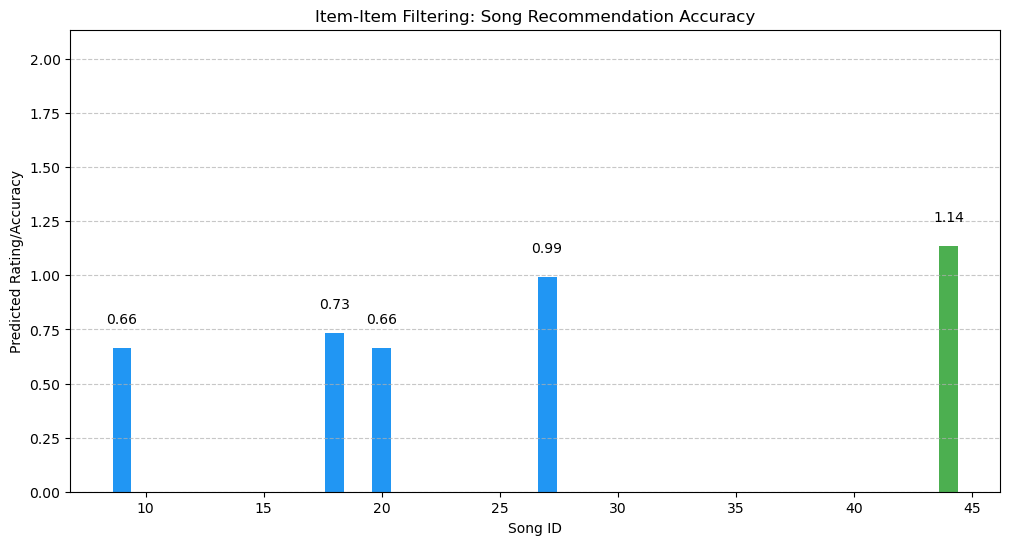

User-User Filtering Recommendations for New User (Based on Preferences):


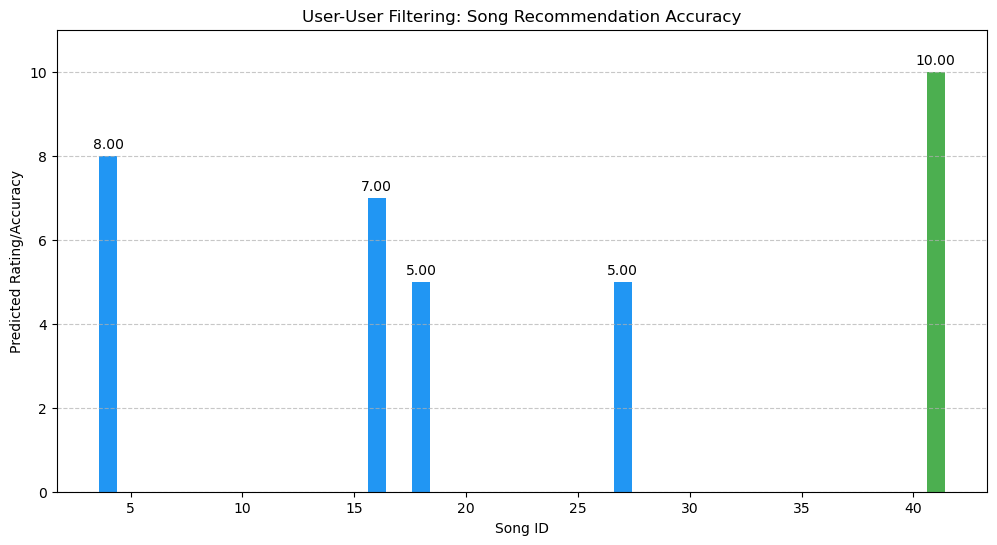

Item-Item Filtering Recommendations (Existing User):
44    1.135551
27    0.992504
18    0.734058
20    0.664750
9     0.662945
dtype: float64

User-User Filtering Recommendations (New User):
41    10.0
4      8.0
16     7.0
18     5.0
27     5.0
dtype: float64


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Create a larger synthetic dataset with user ratings (user_id, song_id, rating)
data = {
    'user_id': np.random.choice(range(1, 101), 1000),  # 100 users
    'song_id': np.random.choice(range(1, 51), 1000),   # 50 songs
    'rating': np.random.randint(1, 6, size=1000)        # Ratings between 1 and 5
}
df = pd.DataFrame(data)

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)

# Function to get song recommendations for new users (user-user filtering based on initial preferences)
def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    return recommendations.nlargest(5)

# Function to get song recommendations for existing users based on item-item filtering
def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5)

    return recommendations.nlargest(5)

# Function to plot the comparison between songs with their accuracy/precision values
def plot_song_accuracy_comparisons(recommendations, title):
    songs = list(recommendations.index)
    song_scores = [recommendations[song] for song in songs]

    plt.figure(figsize=(12, 6))

    # Colors for clarity
    colors = ['#2196F3' if score != max(song_scores) else '#4CAF50' for score in song_scores]  # Highlight the recommended song

    # Bar chart showing accuracy/precision values for each song
    plt.bar(songs, song_scores, color=colors)

    # Add accuracy values to each bar
    for i, score in enumerate(song_scores):
        plt.text(songs[i], score + 0.1, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Predicted Rating/Accuracy')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(song_scores) + 1)  # Set y-axis limit to leave space for labels
    plt.show()

# Main function to handle recommendations for both new and existing users
def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        recommendations = get_user_user_recommendations_for_new_user(preferences)
        plot_song_accuracy_comparisons(recommendations, 'User-User Filtering: Song Recommendation Accuracy')
        return recommendations
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        recommendations = get_item_item_recommendations_for_existing_user(user_id)
        plot_song_accuracy_comparisons(recommendations, 'Item-Item Filtering: Song Recommendation Accuracy')
        return recommendations
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")

# Example usage
existing_user = 1  # An existing user
new_user_preferences = [1, 2, 3]  # New user preferences (liked song IDs)

# Get recommendations for existing user using item-item filtering
item_item_recommendations = recommend_songs(user_id=existing_user)

# Get recommendations for new user using user-user filtering
user_user_recommendations = recommend_songs(preferences=new_user_preferences)

# Print recommendations
print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)
